In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
import pycountry

os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray

# import pandas as pd
import modin.pandas as pd
import ray
ray.init(ignore_reinit_error=True)

from scipy import stats

import warnings
warnings.filterwarnings("ignore")



In [115]:
%run ./module_P2_utils.ipynb

In [105]:
df = pd.read_pickle("./df_01_cleaned.pkl")

# ANALYSIS

Main features that we'll anaylise below :

| Feature | Type |
|-----|-----|
code	                | object	            |0.000000
states	                | object	            |0.000000
states_en	            | object	            |0.000000
states_tags	            | object	            |0.000000
created_datetime	    | datetime64[ns, UTC]	|0.000000
last_modified_datetime	| datetime64[ns, UTC]	|0.000000
creator	                | object	            |0.000201
pnns_groups_2	        | object	            |0.009807
pnns_groups_1	        | object	            |0.009907
countries	            | object	            |0.307572
countries_tags	        | object	            |0.307824
countries_en	        | object	            |0.307824
product_name	        | object	            |4.101583
energy_100g	            | float64               |20.664821
proteins_100g	        | float64               |21.001209
fat_100g	            | float64               |21.063015
carbohydrates_100g	    | float64               |21.081069
sugars_100g	            | float64               |21.867249
saturated-fat_100g	    | float64               |23.229649
energy-kcal_100g	    | float64               |23.248005
salt_100g	            | float64               |25.224544
sodium_100g	            | float64               |25.224695


In particular, let's investigate pnns_groups_1 & pnns_groups_2 [PNNS website](https://www.mangerbouger.fr/PNNS) related to:

* energy_100g
* proteins_100g
* fat_100g
* carbohydrates_100g
* sugars_100g
* saturated-fat_100g
* energy-kcal_100g
* salt_100g
* sodium_100g

First, we need to check for existing outliers, and remove them in order to get a good analysis afterwards

## Outliers analysis

### Outliers for Quantitative Values

In [106]:
for col in df.select_dtypes('float').columns:
    print(col)

additives_n
ingredients_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_n
nutriscore_score
nova_group
energy-kcal_100g
energy_100g
fat_100g
saturated-fat_100g
carbohydrates_100g
sugars_100g
proteins_100g
salt_100g
sodium_100g
nutrition-score-fr_100g


In [107]:
modes = getMultiModes(df, df.select_dtypes('float').columns)
modes

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

All our features have only one mode, we may expect them to follow a normal distribution, but we need to analyse deeper

In [108]:
df.select_dtypes('float').agg(agg_func).T

,std,skew,kurtosis,mean,median,var,mad,prod,sum
additives_n,2.90,2.38,8.47,2.03,1.00,8.41,2.08,0.00,1465968.00
ingredients_from_palm_oil_n,0.14,7.09,50.82,0.02,0.00,0.02,0.04,0.00,14661.00
ingredients_that_may_be_from_palm_oil_n,0.30,5.36,36.94,0.07,0.00,0.09,0.13,0.00,50725.00
nutriscore_score,8.84,0.10,-0.94,9.10,10.00,78.18,7.63,0.00,6547608.00
nova_group,0.97,-1.65,1.43,3.42,4.00,0.95,0.77,inf,2158324.00
energy-kcal_100g,81251283087.72,1222.32,1503466.53,71277250.65,260.00,6601771003401592635392.00,142553591.11,0.00,108782983562897.02
energy_100g,5306931587020785931728607601085372170240.00,1256.01,1577561.00,4225230522869726631061498661649252352.00,1079.00,28163522869318955277429537580043184023559817948...,8450455689077461886480510870196584448.00,0.00,6665558888888888950360610417759390841962496.00
fat_100g,87799541163.78,1252.85,1569643.00,70079644.28,7.00,7708759428570484310016.00,140159171.45,0.00,110000023080126.70
saturated-fat_100g,16.56,682.82,678025.81,5.10,1.80,274.25,5.44,0.00,7792983.01
carbohydrates_100g,632.90,1135.27,1350921.00,28.86,15.10,400567.09,25.67,0.00,45290543.10


In [109]:
df.select_dtypes('float').describe().T

,count,mean,std,min,25%,50%,75%,max
additives_n,722441.00,2.03,2.90,0.00,0.00,1.00,3.00,49.00
ingredients_from_palm_oil_n,722441.00,0.02,0.14,0.00,0.00,0.00,0.00,3.00
ingredients_that_may_be_from_palm_oil_n,722441.00,0.07,0.30,0.00,0.00,0.00,0.00,6.00
nutriscore_score,719218.00,9.10,8.84,-15.00,1.00,10.00,16.00,40.00
nova_group,630683.00,3.42,0.97,1.00,3.00,4.00,4.00,4.00
energy-kcal_100g,1526195.00,71277250.65,81251283087.72,0.00,100.00,260.00,400.00,100000000376832.00
energy_100g,1577561.00,4225230522869726631061498661649252352.00,5306931587020785931728607601085372170240.00,0.00,418.00,1079.00,1674.00,6665558888888888950360610417759390841962496.00
fat_100g,1569643.00,70079644.28,87799541163.78,0.00,0.80,7.00,21.20,110000001253376.00
saturated-fat_100g,1526560.00,5.10,16.56,0.00,0.10,1.80,7.09,16700.00
carbohydrates_100g,1569284.00,28.86,632.90,-1.00,3.50,15.10,53.00,762939.00


Definitively, some features contains outliers, especially for instance `energy_100g` : std and range are very high

Let's see graphically using box plots.

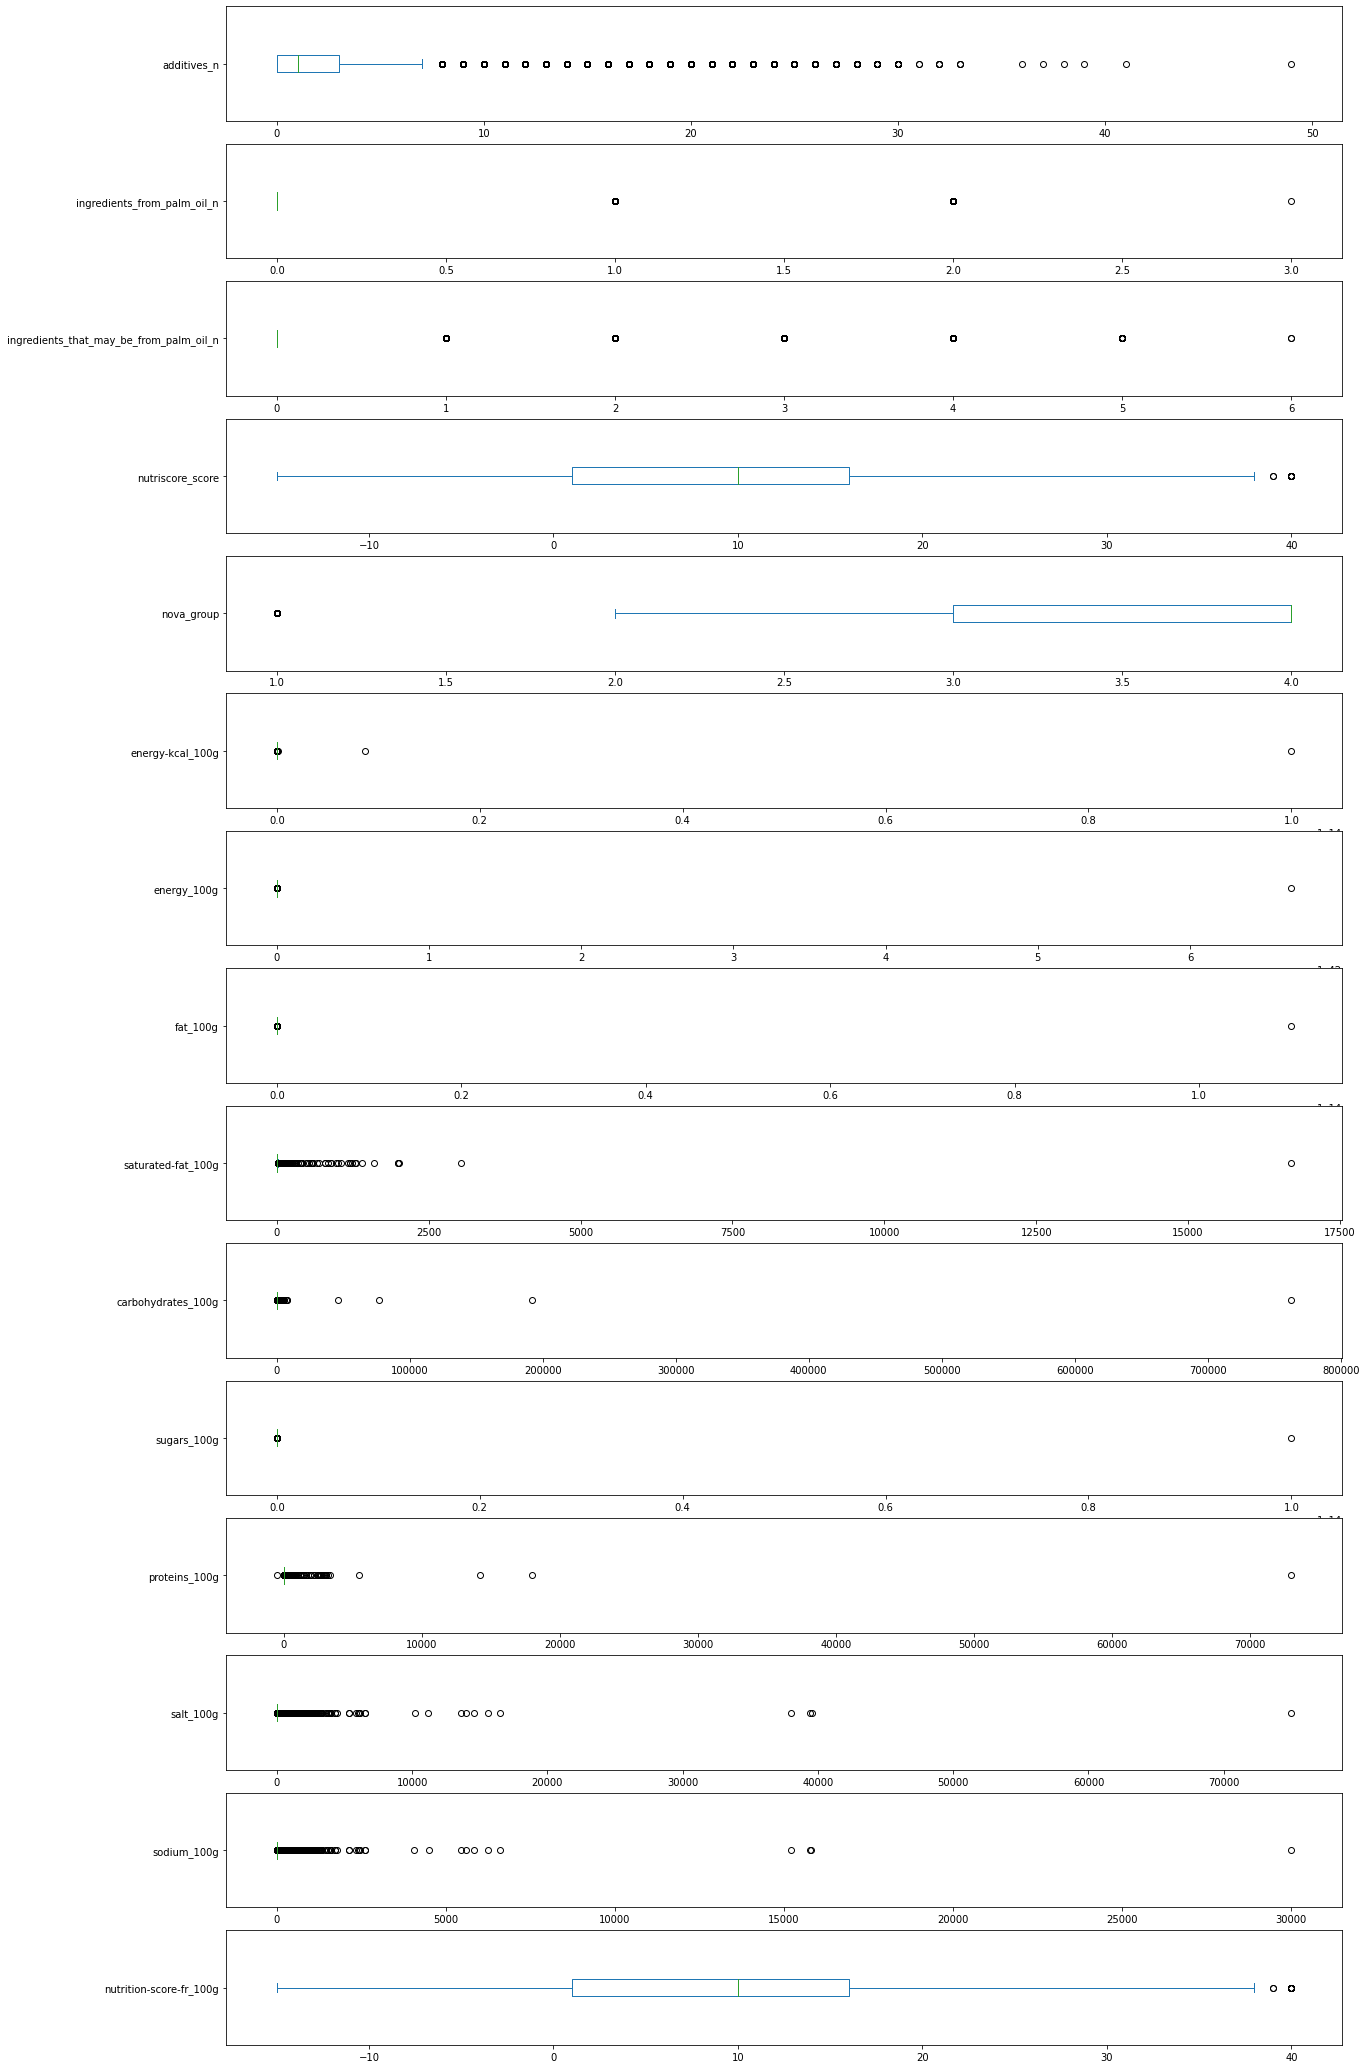

In [110]:
plotBoxes(df, df.select_dtypes('float').columns)

We see that in fact, almost all of the quantitative features have outliers, so we'll have to remove them

others are in fact categorical features: 
* nova_group
* ingredients_from_palm_oil_n
* ingredients_that_may_be_from_palm_oil_n

We should convert them to panda.categories for convenience

In [111]:
df['nova_group'] = df['nova_group'].astype('category')
df['ingredients_from_palm_oil_n'] = df['ingredients_from_palm_oil_n'].astype('category')
df['ingredients_that_may_be_from_palm_oil_n'] = df['ingredients_that_may_be_from_palm_oil_n'].astype('category')

Let's see graphically the distribution of the features

distribution of quantitative values


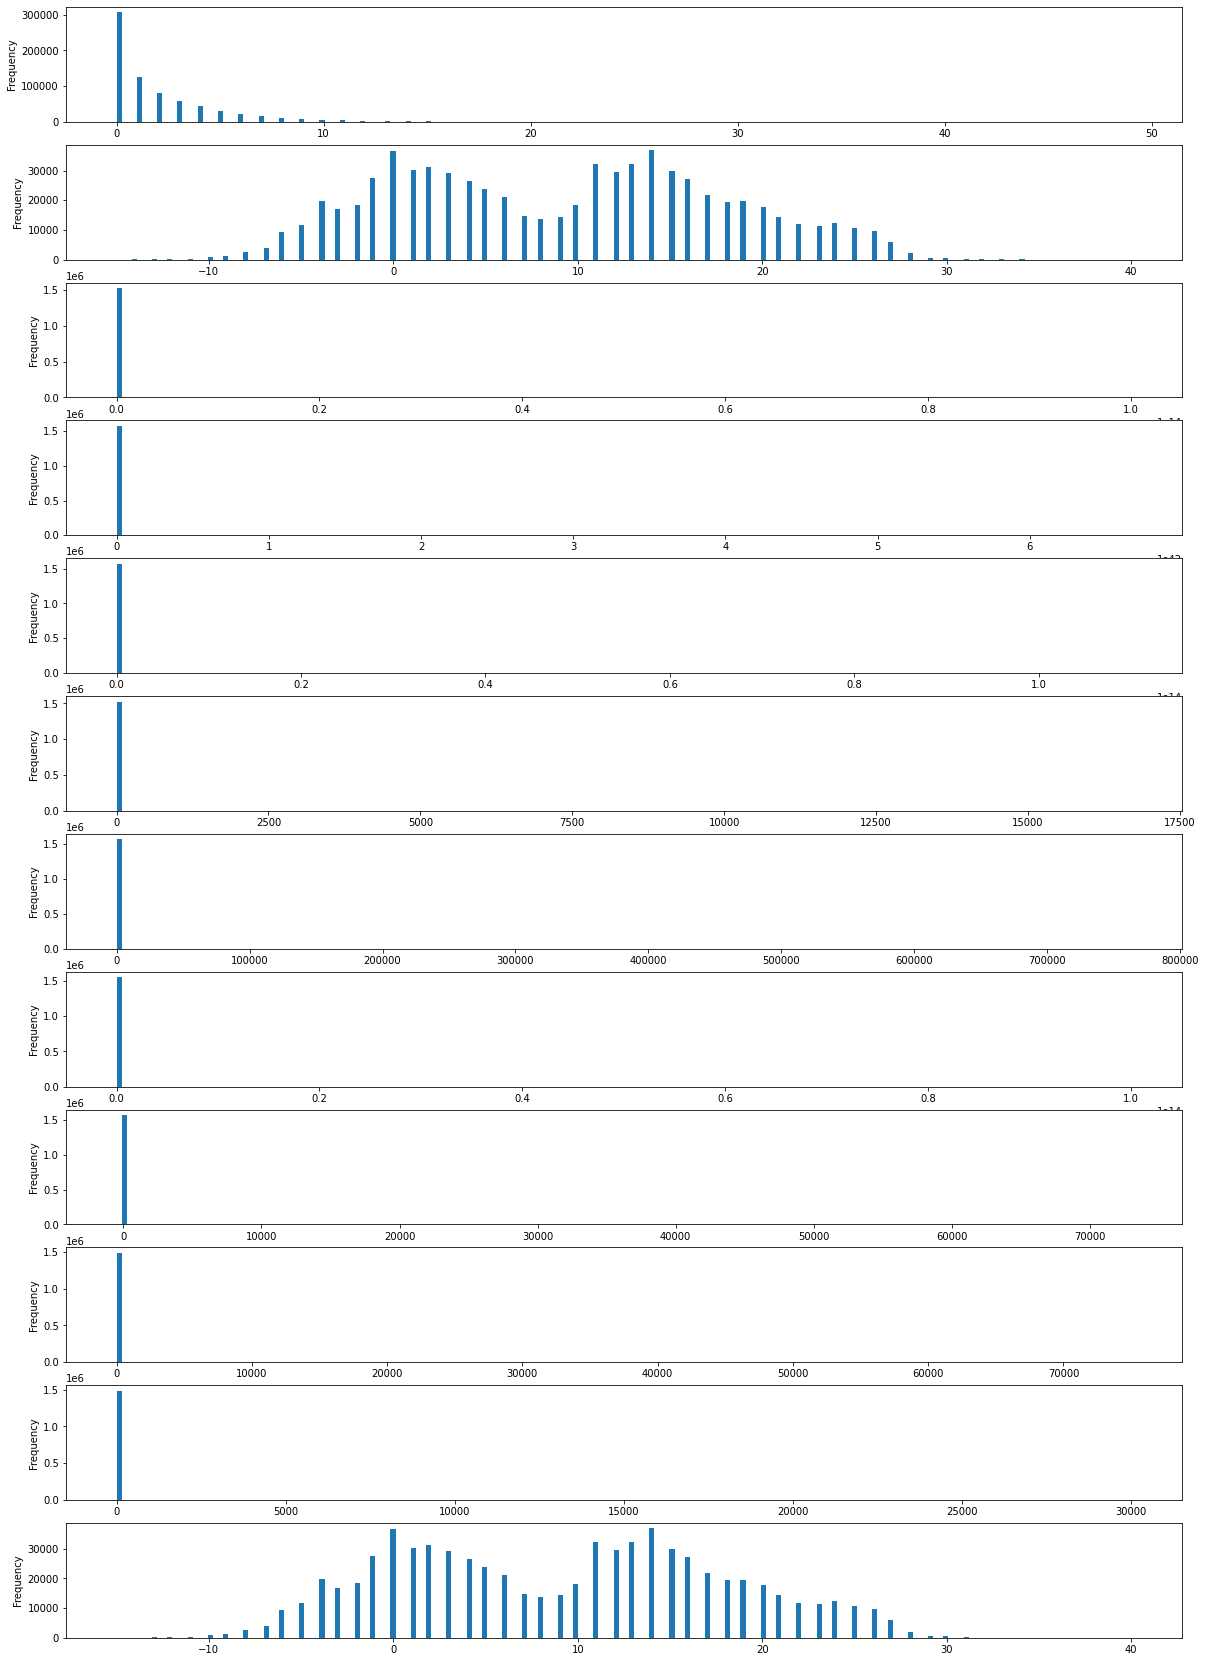

In [112]:
plotDist(df, df.select_dtypes('float').columns)

Reminder, what are the rates of missing values for these features ?

In [113]:
(df.select_dtypes('float').isna().mean().sort_values()) * 100

energy_100g               20.66
proteins_100g             21.00
fat_100g                  21.06
carbohydrates_100g        21.08
sugars_100g               21.87
saturated-fat_100g        23.23
energy-kcal_100g          23.25
salt_100g                 25.22
sodium_100g               25.22
additives_n               63.67
nutrition-score-fr_100g   63.83
nutriscore_score          63.83
dtype: float64

Let's apply our function to remove the outliers

We have implemented two methods in our custom library : Z-Score and IQ Range

Let's consider feature having outliers if they have `std > 10`

In [114]:
has_Outliers = df.select_dtypes('float').std() > 10
has_Outliers.index[has_Outliers].values

array(['energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g'], dtype=object)

In [118]:
# %run ./module_P2_utils.ipynb

In [119]:
removeOutliers(df, has_Outliers.index[has_Outliers].values)

Now that outliers are removed, let's see the results

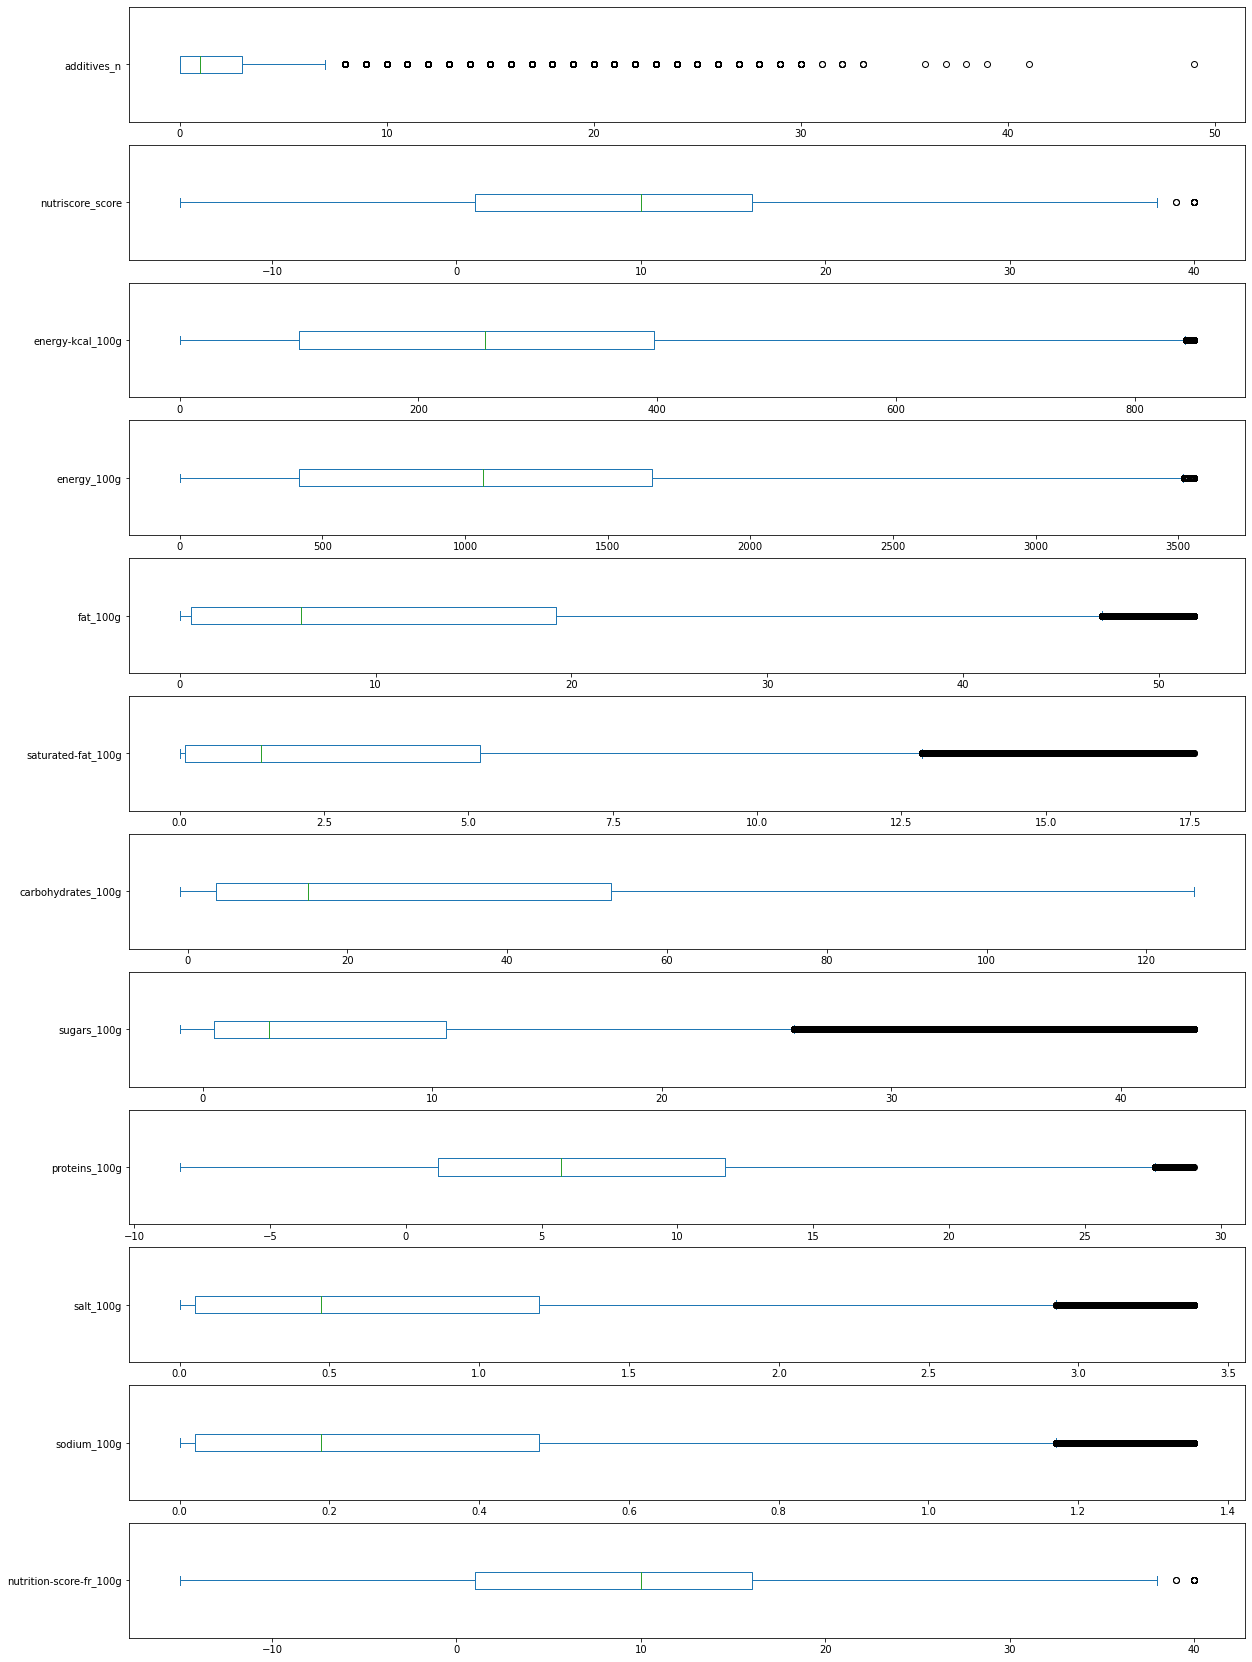

In [120]:
plotBoxes(df, df.select_dtypes('float').columns)

This is way better, despite some outliers are still present.

let's see the distributions

In [123]:
%run ./module_P2_utils.ipynb

distribution of quantitative values


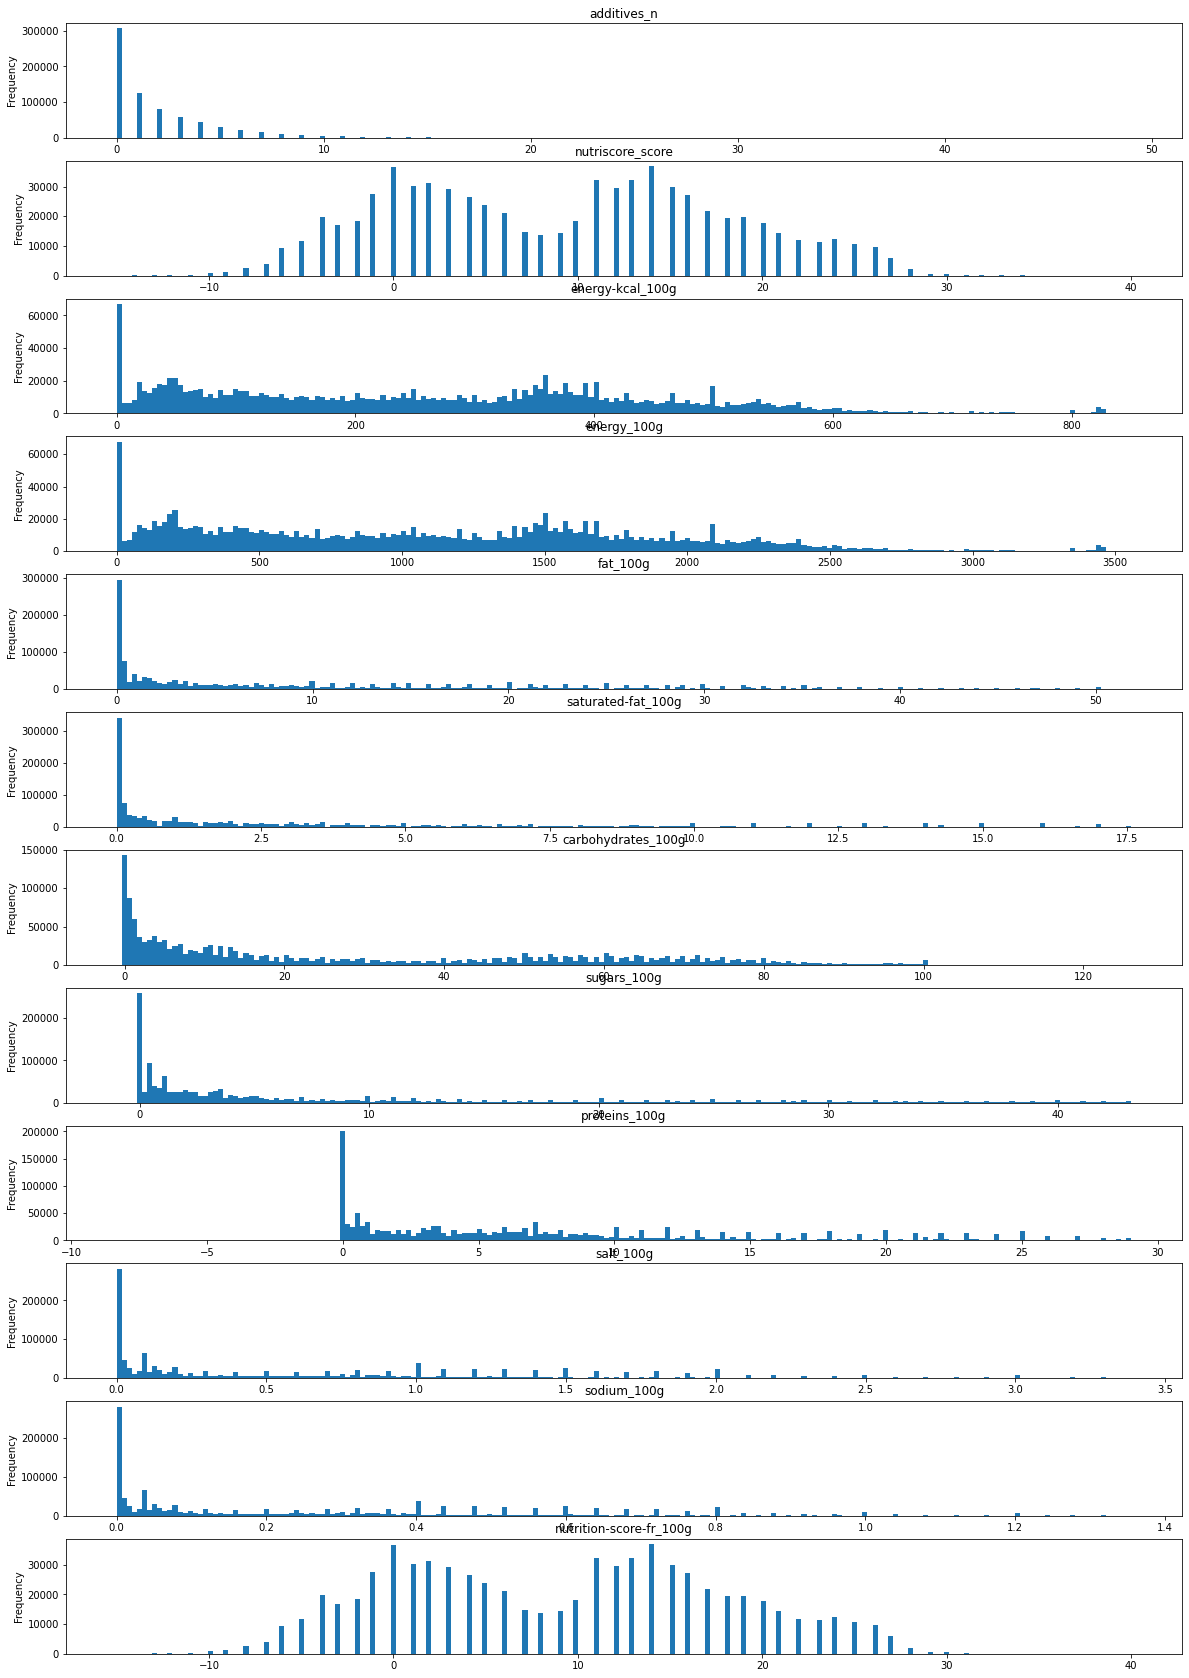

In [124]:
plotDist(df, df.select_dtypes('float').columns)

In [125]:
df.select_dtypes('float').agg(agg_func).T

,std,skew,kurtosis,mean,median,var,mad,prod,sum
additives_n,2.90,2.38,8.47,2.03,1.00,8.41,2.08,0.00,1465968.00
nutriscore_score,8.84,0.10,-0.94,9.10,10.00,78.18,7.63,0.00,6547608.00
energy-kcal_100g,184.24,0.40,-0.56,265.60,256.00,33945.03,156.66,0.00,400643936.55
energy_100g,769.96,0.40,-0.56,1108.27,1063.00,592842.21,655.02,0.00,1728652514.93
fat_100g,12.61,1.09,0.24,11.30,6.19,158.91,10.47,0.00,17083977.83
saturated-fat_100g,4.46,1.43,1.05,3.43,1.40,19.86,3.52,0.00,4842419.52
carbohydrates_100g,27.97,0.71,-0.86,28.05,15.10,782.23,24.70,0.00,44018582.12
sugars_100g,10.58,1.65,1.76,7.69,2.90,111.94,8.11,-0.00,10733454.61
proteins_100g,7.43,1.00,0.08,7.63,5.70,55.21,5.99,-0.00,11645002.60
salt_100g,0.77,1.07,0.40,0.72,0.47,0.60,0.64,0.00,1005824.05


In [126]:
df.select_dtypes('float').describe().T

,count,mean,std,min,25%,50%,75%,max
additives_n,722441.00,2.03,2.90,0.00,0.00,1.00,3.00,49.00
nutriscore_score,719218.00,9.10,8.84,-15.00,1.00,10.00,16.00,40.00
energy-kcal_100g,1508434.00,265.60,184.24,0.00,100.00,256.00,397.00,850.00
energy_100g,1559777.00,1108.27,769.96,0.00,418.00,1063.00,1657.00,3556.00
fat_100g,1512475.00,11.30,12.61,0.00,0.60,6.19,19.20,51.80
saturated-fat_100g,1410076.00,3.43,4.46,0.00,0.10,1.40,5.20,17.57
carbohydrates_100g,1569059.00,28.05,27.97,-1.00,3.50,15.10,53.00,126.00
sugars_100g,1395753.00,7.69,10.58,-1.00,0.50,2.90,10.60,43.21
proteins_100g,1526322.00,7.63,7.43,-8.33,1.20,5.70,11.76,29.03
salt_100g,1393970.00,0.72,0.77,0.00,0.05,0.47,1.20,3.39


Now the figures are more consistent

In [127]:
df.to_pickle("./df_02_quanti.pkl")

## Analysis

In [ ]:
sns.displot(data=df, hue='nutriscore_grade', x='nutriscore_score', kind='ecdf')

In [ ]:
df['nutriscore_grade_cat'] = df['nutriscore_grade'].astype('category')

In [ ]:
df['nutriscore_grade_cat'].dropna().cat.categories

In [ ]:
df['nutriscore_grade_cat'].dropna().cat.codes.unique()

In [ ]:
# show product names for country FR
df['product_name'].unique().size

In [ ]:
pd.DataFrame({'columns': df.columns, 'multimode': getMultiModes(df, df.columns)})

In [ ]:
df['energy_100g'].agg(["skew", "kurtosis"])

In [ ]:
isMultiMode(df, 'energy_100g')

Despite feature is uni mode, skew is positive and high, so Z-score method cannot be applied here

Therefore we prefer to apply IQR method.


## Quantile Analysis



### Basic Quantile analysis

In [ ]:
df['energy_100g_qc'] = pd.qcut(df['energy_100g'], q=10)
df['energy_100g_qc'].head()

In [ ]:
df['energy_100g_qc'].value_counts()

In [ ]:
df['energy_100g_qc'].head()

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

#### IQR

In [ ]:
df['energy_100g'] = df_bck['energy_100g']

In [ ]:
df['energy_100g'].describe()

In [ ]:
df['energy_100g'].plot(kind='box', vert=False)

Remove outliers following 'IQR' method

In [ ]:
dropOutlierIQR(df, 'energy_100g')

In [ ]:
df['energy_100g'].describe()

In [ ]:
df['energy_100g'].agg(["min", "max", "median", "mean", "var", "std", "skew", "kurtosis"]).T

In [ ]:
df['energy_100g'].plot(kind='box', vert=False)

We have very rare outstanding values, so they can be classified as outliers (outliers must be rare, otherwise question of interest in the dataset must be set). They won't have statiscial impact

what to do with outliers ?
* remove lines
* replace w/ Least Absolute Deviation Method
* replace w/ Robust Statistical Method
* replace by Least Squares Method


In [ ]:
df['energy_100g'].dropna().plot(kind='hist', bins=100)

Implementation of outliers removal based on IQR method

## TODO :
SI la variance / ecart type sont tres grands (rapport ) quoi ?) alors on applique la suppression des outliers

In [ ]:
dropOutliersIQR(df, ['energy_100g', 'energy-kcal_100g', 'fat_100g',
                     'saturated-fat_100g',
                     'carbohydrates_100g',
                     'sugars_100g',
                     'proteins_100g',
                     'salt_100g',
                     'sodium_100g' ])

In [ ]:
dropOutliersZscore(df, ['energy_100g', 'energy-kcal_100g', 'fat_100g',
                        'saturated-fat_100g',
                        'carbohydrates_100g',
                        'sugars_100g',
                        'proteins_100g',
                        'salt_100g',
                        'sodium_100g' ])

# Testing Functions

In [ ]:
df['sodium_tmp'] = df['sodium_100g']

In [ ]:
stats_desc(df['sodium_100g'])

In [ ]:
df['sodium_100g'].plot(kind='hist')

In [ ]:
df['sodium_100g'].plot(kind='box', vert=False)

In [ ]:
%run ./module_P2_utils.ipynb

In [ ]:
isMultiMode(df, 'sodium_100g')

In [ ]:
removeOutlier(df, 'sodium_100g')

In [ ]:
stats_desc(df['sodium_100g'])

In [ ]:
dropOutlierZscore(df, 'sodium_100g')

In [ ]:
dropOutlierIQR(df, 'sodium_100g')

In [ ]:
df['sodium_100g'] = df['sodium_tmp']

## Analysis

In [ ]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_1'] )

In [ ]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_2'] )

In [ ]:
plt.figure(figsize=(20,20))
# sns.displot(df, x='nutriscore_grade')
sns.displot(df, x='nutriscore_score', hue='nutriscore_grade', kind='ecdf')
plt.savefig("nutriscore_grade_multivariate_analysis.png", format='png', dpi=150)
sns.displot(df, x='nutriscore_score', y='ecoscore_score_fr', hue='nutriscore_grade')
# sns.displot(df, x='nutriscore_score', y= 'nova_group', hue='nutriscore_grade', kind='kde')
# sns.displot(df, x='nutriscore_score', col='nutriscore_grade')
plt.savefig("nutriscore_ecoscore_multivariate_analysis.png", format='png', dpi=150)

In [ ]:
df['nutriscore_grade'].value_counts(normalize=True).plot.pie()

In [ ]:
df['nutriscore_score'].dropna().value_counts().sort_values(ascending=False)


We can see that some columns still have lots of empty values, but also that several rows have almost (or all) the features provided,
which is good for further analysis



In [ ]:
# most filled features
df.columns[[0, 1, 11, 12, 13, 25, 26, 27, 28, 29]]

In [ ]:
df.columns.get_loc('nutriscore_grade')